In [1]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch

num_classes = 14

model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.pth',map_location='cuda'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23956\1939192362.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.p

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [2]:
import torch
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image

In [3]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transform=None):
        self.coco = CocoDetection(root, annFile)
        self.transform = transform
    
    def __getitem__(self, index):
        img, target = self.coco[index]

        boxes = []
        labels = []

        for obj in target:
            x,y,w,h = obj['bbox']
            boxes.append([x,y,x+w,y+h])
            labels.append(obj['category_id'])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if boxes.numel() == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transform:
            img = self.transform(img)

        return img, target
    
    def __len__(self):
        return len(self.coco)

In [4]:
def get_transform():
    return transforms.Compose([
        transforms.ToTensor()
    ])

In [5]:
train_root = 'dataset/train'
train_ann = 'dataset/train/_annotations.coco.json'
val_root = 'dataset/valid'
val_ann = 'dataset/valid/_annotations.coco.json'
test_root = 'dataset/test'
test_ann = 'dataset/test/_annotations.coco.json'

train_dataset = CocoDataset(train_root, train_ann, transform=get_transform())
val_dataset = CocoDataset(val_root, val_ann, transform=get_transform())
test_dataset = CocoDataset(test_root, test_ann, transform=get_transform())

print(f"Train Samples: {len(train_dataset)}")
print(f"Val Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Train Samples: 2634
Val Samples: 966
Test Samples: 458


In [6]:
def collate_batch(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_batch, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch, pin_memory=True)

In [7]:
from torchvision.ops import box_iou
from tqdm import tqdm
import torch

In [8]:
import torch
from torchvision.ops import box_iou
from tqdm import tqdm

iou_threshold = 0.5
correct = 0
total = 0

loop = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, targets in loop:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for i, output in enumerate(outputs):
            boxes = output['boxes']
            labels = output['labels']
            scores = output['scores']

            # Keep predictions with score > 0.5
            mask = scores > 0.5
            pred_boxes = boxes[mask]
            pred_labels = labels[mask]

            target_boxes = targets[i]['boxes']
            target_labels = targets[i]['labels']

            if len(pred_boxes) == 0 or len(target_boxes) == 0:
                continue

            # Compute IoU
            iou = box_iou(pred_boxes, target_boxes)  # both are tensors now

            # Count correct predictions: IoU > threshold & matching labels
            max_iou, max_idx = iou.max(dim=1)
            for j in range(len(pred_boxes)):
                if max_iou[j] > iou_threshold and pred_labels[j] == target_labels[max_idx[j]]:
                    correct += 1
                total += 1

accuracy = correct / total if total > 0 else 0
print(f"Correct: {correct}")
print(f"Total: {total}")
print(f"IoU-based Accuracy: {accuracy:.4f}")


Testing:   0%|          | 0/115 [00:00<?, ?it/s]

Testing: 100%|██████████| 115/115 [02:39<00:00,  1.38s/it]

Correct: 4396
Total: 7512
IoU-based Accuracy: 0.5852


In [10]:
for name, param in model.named_parameters():
    print(f"{name} | Trainable: {param.requires_grad} | Shape: {param.shape}")

backbone.body.conv1.weight | Trainable: False | Shape: torch.Size([64, 3, 7, 7])
backbone.body.layer1.0.conv1.weight | Trainable: False | Shape: torch.Size([64, 64, 1, 1])
backbone.body.layer1.0.conv2.weight | Trainable: False | Shape: torch.Size([64, 64, 3, 3])
backbone.body.layer1.0.conv3.weight | Trainable: False | Shape: torch.Size([256, 64, 1, 1])
backbone.body.layer1.0.downsample.0.weight | Trainable: False | Shape: torch.Size([256, 64, 1, 1])
backbone.body.layer1.1.conv1.weight | Trainable: False | Shape: torch.Size([64, 256, 1, 1])
backbone.body.layer1.1.conv2.weight | Trainable: False | Shape: torch.Size([64, 64, 3, 3])
backbone.body.layer1.1.conv3.weight | Trainable: False | Shape: torch.Size([256, 64, 1, 1])
backbone.body.layer1.2.conv1.weight | Trainable: False | Shape: torch.Size([64, 256, 1, 1])
backbone.body.layer1.2.conv2.weight | Trainable: False | Shape: torch.Size([64, 64, 3, 3])
backbone.body.layer1.2.conv3.weight | Trainable: False | Shape: torch.Size([256, 64, 1, 

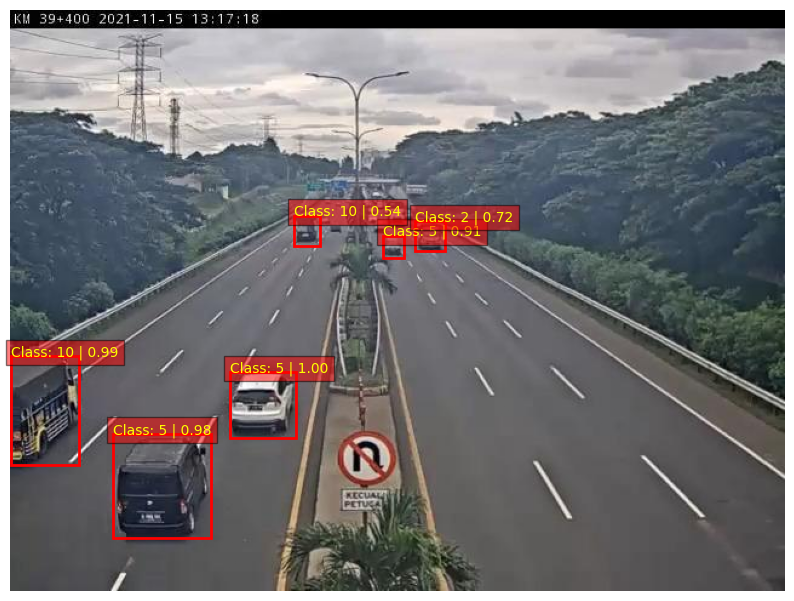

In [12]:
import matplotlib.pyplot as plt
import torch

model.eval()

images, targets = next(iter(val_loader))

image = images[0].to(device)
target = targets[0]

with torch.no_grad():
    prediction = model([image])[0]

img = image.cpu().permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(img)
ax = plt.gca()

# Draw predicted boxes with score > 0.5
for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score > 0.5:
        x1, y1, x2, y2 = box.cpu()
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   fill=False, color='red', linewidth=2))
        ax.text(x1, y1, f"Class: {label.item()} | {score:.2f}", color='yellow', fontsize=10,
                bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()

In [13]:
# Index should match your dataset label IDs
class_names = [
    "background",    # 0
    "big bus",       # 1
    "big truck",     # 2
    "bus-l-",        # 3
    "bus-s-",        # 4
    "car",           # 5
    "mid truck",     # 6
    "small bus",     # 7
    "small truck",   # 8
    "truck-l-",      # 9
    "truck-m-",      # 10
    "truck-s-",      # 11
    "truck-xl-"      # 12
]


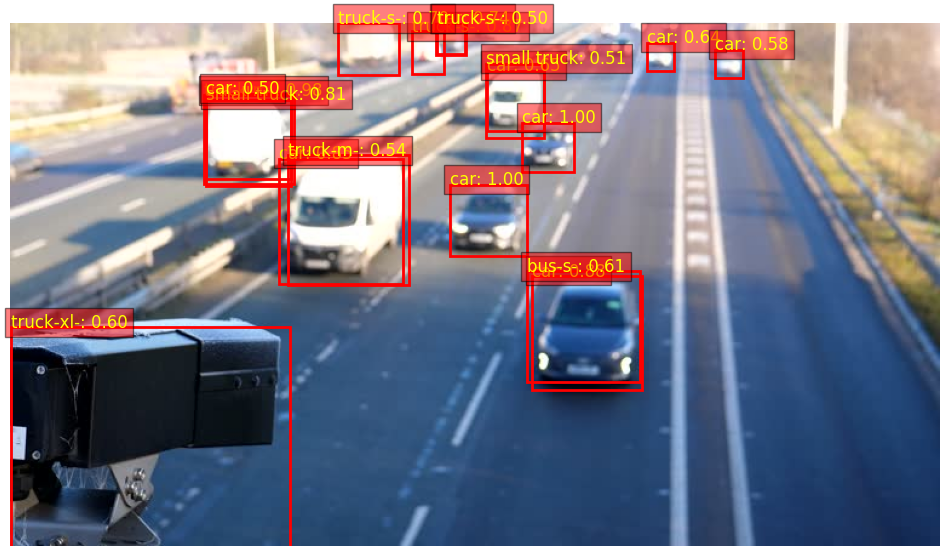

In [19]:
from PIL import Image
import torchvision.transforms as T

# Load image
image_path = "z.jpg"  
image = Image.open(image_path).convert("RGB")

transform = T.Compose([
    T.ToTensor()
])
image_tensor = transform(image).to(device)

with torch.no_grad():
    outputs = model([image_tensor])[0] 

img = image_tensor.cpu().permute(1, 2, 0)

plt.figure(figsize=(12, 12))
plt.imshow(img)
ax = plt.gca()

for box, label, score in zip(outputs['boxes'], outputs['labels'], outputs['scores']):
    if score > 0.5:
        x1, y1, x2, y2 = box.cpu()
        cls_name = class_names[label.item()]
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   fill=False, color='red', linewidth=2))
        ax.text(x1, y1, f"{cls_name}: {score:.2f}", color='yellow', fontsize=12,
                bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()

